# Exploración y reestructuración de datos

Realizamos la reestructura del dataset de Eventos de Violencia con Armas, generando nuevos campos a partir de los originales con la finalidad de que esto nos permita encontrar otros tipos de relaciones y correlaciones.

A partir de las correlaciones haremos la prueba de entrenar un modelo de regresión lineal simple o múltiple, según la necesidad, con el fin de validar luego el rendimiento del mismo.

In [1]:
#importando librerias necesarias
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

#importando datos
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Proyecto DSCH/gun_violence'
gun_violence = pd.read_csv('gun_violence_data.csv')

Mounted at /content/gdrive
/content/gdrive/MyDrive/Proyecto DSCH/gun_violence


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Transformando la fecha en columnas individuales
gun_violence['date'] = pd.to_datetime(gun_violence['date'])
gun_violence['day'] = gun_violence['date'].dt.day
gun_violence['month'] = gun_violence['date'].dt.month
gun_violence['year'] = gun_violence['date'].dt.year
gun_violence['day_of_the_week'] = gun_violence['date'].dt.dayofweek

In [3]:
#Eliminando outliers y limitando las fechas

#gun_violence=gun_violence.dropna(subset=['n_guns_involved'])
gun_violence=gun_violence.drop(['congressional_district','state_senate_district', 'state_house_district'], axis=1)
gun_violence = gun_violence.drop(gun_violence[gun_violence.year <= 2013].index)
gun_violence = gun_violence.drop(gun_violence[gun_violence.year >= 2018].index)
gun_violence = gun_violence.drop(gun_violence[gun_violence.n_guns_involved > 20].index)
gun_violence = gun_violence.drop(gun_violence[gun_violence.n_killed >= 10].index)

#Factorizando estados y ciudades
gun_violence['state_n'] = pd.factorize(gun_violence['state'])[0] + 1
gun_violence['city_n'] = pd.factorize(gun_violence['city_or_county'])[0] + 1

In [4]:
#Funciones para separar datos de columnas individuales a múltiples

def attr_split(attr):
  return attr.split('||')

def attr_parse(attr):
  if attr.__contains__('::'): return attr.split('::')
  elif attr.__contains__(':'): return attr.split(':')

  return None

def parse(attr):
  items = [None] * 20
  if (attr != attr): return items

  if attr.__contains__('||'):
    splited = attr_split(attr)
    for x in splited:
      string = attr_parse(x)
      try:
        if int(string[0]) >= 20: break
      except:
        return items

      if string is not None: items[int(string[0])] = string[1]
  else:
    string = attr_parse(attr)
    if string is not None: items[int(string[0])] = string[1]
    
  return items

def parse2(attr):
  if attr != attr: return []
  elif len(attr) == 0: return []
  elif attr.__contains__('||'): return attr_split(attr)
  else: return [attr]

def participant_type(arr, participant_type, is_victim, sum_variable):
  total = 0
  for i in range(0,20):
    if is_victim:
      if participant_type[i] != 'Victim': continue
    else:
      if participant_type[i] != 'Subject-Suspect': continue

    if sum_variable == arr[i]: total += 1

  return total

In [5]:
#separación de datos en columnas aplicando la función de parseo

gun_violence['gun_stolen'] = gun_violence['gun_stolen'].apply(parse)
gun_violence['gun_type'] = gun_violence['gun_type'].apply(parse)
gun_violence['incident_characteristics'] = gun_violence['incident_characteristics'].apply(parse2)
gun_violence['participant_age'] = gun_violence['participant_age'].apply(parse)
gun_violence['participant_age_group'] = gun_violence['participant_age_group'].apply(parse)
gun_violence['participant_gender'] = gun_violence['participant_gender'].apply(parse)
gun_violence['participant_status'] = gun_violence['participant_status'].apply(parse)
gun_violence['participant_type'] = gun_violence['participant_type'].apply(parse)

In [6]:
#inicializando nuevas columnas
gun_violence['participant_male'] = 0
gun_violence['participant_female'] = 0
gun_violence['participant_child'] = 0
gun_violence['participant_teen'] = 0
gun_violence['participant_adult'] = 0
gun_violence['participant_injured'] = 0
gun_violence['participant_injured_arrested'] = 0
gun_violence['participant_unharmed'] = 0
gun_violence['participant_unharmed_arrested'] = 0
gun_violence['participant_killed'] = 0
gun_violence['participant_victim'] = 0
gun_violence['participant_subject_suspect'] = 0


gun_violence['participant_victim_male'] = 0
gun_violence['participant_victim_female'] = 0
gun_violence['participant_victim_child'] = 0
gun_violence['participant_victim_teen'] = 0
gun_violence['participant_victim_adult'] = 0
gun_violence['participant_victim_injured'] = 0
gun_violence['participant_victim_injured_arrested'] = 0
gun_violence['participant_victim_unharmed'] = 0
gun_violence['participant_victim_unharmed_arrested'] = 0
gun_violence['participant_victim_killed'] = 0
gun_violence['participant_suspect_male'] = 0
gun_violence['participant_suspect_female'] = 0
gun_violence['participant_suspect_child'] = 0
gun_violence['participant_suspect_teen'] = 0
gun_violence['participant_suspect_adult'] = 0
gun_violence['participant_suspect_injured'] = 0
gun_violence['participant_suspect_injured_arrested'] = 0
gun_violence['participant_suspect_unharmed'] = 0
gun_violence['participant_suspect_unharmed_arrested'] = 0
gun_violence['participant_suspect_killed'] = 0

In [7]:
def count_by(arr, attr):
  return attr.count(attr)

  
gun_violence['participant_male'] = gun_violence.apply(lambda row: count_by(row["participant_gender"], 'Male'), axis=1)
gun_violence['participant_female'] = gun_violence.apply(lambda row: count_by(row["participant_gender"], 'Female'), axis=1)
gun_violence['participant_child'] = gun_violence.apply(lambda row: count_by(row["participant_age_group"], 'Child 0-11'), axis=1)
gun_violence['participant_teen'] = gun_violence.apply(lambda row: count_by(row["participant_age_group"], 'Teen 12-17'), axis=1)
gun_violence['participant_adult'] = gun_violence.apply(lambda row: count_by(row["participant_age_group"], 'Adult 18+'), axis=1)
gun_violence['participant_injured'] = gun_violence.apply(lambda row: count_by(row["participant_status"], 'Injured'), axis=1)
gun_violence['participant_injured_arrested'] = gun_violence.apply(lambda row: count_by(row["participant_status"], 'Injured, Arrested'), axis=1)
gun_violence['participant_unharmed'] = gun_violence.apply(lambda row: count_by(row["participant_status"], 'Unharmed'), axis=1)
gun_violence['participant_unharmed_arrested'] = gun_violence.apply(lambda row: count_by(row["participant_status"], 'Unharmed, Arrested'), axis=1)
gun_violence['participant_killed'] = gun_violence.apply(lambda row: count_by(row["participant_status"], 'Killed'), axis=1)
gun_violence['participant_victim'] = gun_violence.apply(lambda row: count_by(row["participant_type"], 'Victim'), axis=1)
gun_violence['participant_subject_suspect'] = gun_violence.apply(lambda row: count_by(row["participant_type"], 'Subject-Suspect'), axis=1)


gun_violence['participant_victim_male'] = gun_violence.apply(lambda row: participant_type(row["participant_gender"], row["participant_type"], True, 'Male'), axis=1)
gun_violence['participant_victim_female'] = gun_violence.apply(lambda row: participant_type(row["participant_gender"], row["participant_type"], True, 'Female'), axis=1)
gun_violence['participant_victim_child'] = gun_violence.apply(lambda row: participant_type(row["participant_age_group"], row["participant_type"], True, 'Child 0-11'), axis=1)
gun_violence['participant_victim_teen'] = gun_violence.apply(lambda row: participant_type(row["participant_age_group"], row["participant_type"], True, 'Teen 12-17'), axis=1)
gun_violence['participant_victim_adult'] = gun_violence.apply(lambda row: participant_type(row["participant_age_group"], row["participant_type"], True, 'Adult 18+'), axis=1)
gun_violence['participant_victim_injured'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], True, 'Injured'), axis=1)
gun_violence['participant_victim_injured_arrested'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], True, 'Injured, Arrested'), axis=1)
gun_violence['participant_victim_unharmed'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], True, 'Male'), axis=1)
gun_violence['participant_victim_unharmed_arrested'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], True, 'Unharmed, Arrested'), axis=1)
gun_violence['participant_victim_killed'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], True, 'Killed'), axis=1)
gun_violence['participant_suspect_male'] = gun_violence.apply(lambda row: participant_type(row["participant_gender"], row["participant_type"], False, 'Male'), axis=1)
gun_violence['participant_suspect_female'] = gun_violence.apply(lambda row: participant_type(row["participant_gender"], row["participant_type"], False, 'Female'), axis=1)
gun_violence['participant_suspect_child'] = gun_violence.apply(lambda row: participant_type(row["participant_age_group"], row["participant_type"], False, 'Child 0-11'), axis=1)
gun_violence['participant_suspect_teen'] = gun_violence.apply(lambda row: participant_type(row["participant_age_group"], row["participant_type"], False, 'Teen 12-17'), axis=1)
gun_violence['participant_suspect_adult'] = gun_violence.apply(lambda row: participant_type(row["participant_age_group"], row["participant_type"], False, 'Adult 18+'), axis=1)
gun_violence['participant_suspect_injured'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], False, 'Injured'), axis=1)
gun_violence['participant_suspect_injured_arrested'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], False, 'Injured, Arrested'), axis=1)
gun_violence['participant_suspect_unharmed'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], False, 'Unharmed'), axis=1)
gun_violence['participant_suspect_unharmed_arrested'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], False, 'Unharmed, Arrested'), axis=1)
gun_violence['participant_suspect_killed'] = gun_violence.apply(lambda row: participant_type(row["participant_status"], row["participant_type"], False, 'Killed'), axis=1)

In [8]:
gun_violence.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,incident_characteristics,latitude,...,participant_suspect_male,participant_suspect_female,participant_suspect_child,participant_suspect_teen,participant_suspect_adult,participant_suspect_injured,participant_suspect_injured_arrested,participant_suspect_unharmed,participant_suspect_unharmed_arrested,participant_suspect_killed
0,92114,2014-01-01,Kentucky,Lexington,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.0507,...,0,0,0,0,0,0,0,0,0,0
1,92117,2014-01-01,Kentucky,Cynthiana,0,1,"[Unknown, None, None, None, None, None, None, ...","[Unknown, None, None, None, None, None, None, ...","[Shot - Wounded/Injured, Accidental Shooting, ...",38.4333,...,1,0,0,0,1,0,0,0,1,0
2,92119,2014-01-01,Kentucky,Louisville,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.2501,...,0,0,0,0,0,0,0,0,0,0
3,92125,2014-01-01,Oklahoma,Lawton,0,0,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shots Fired - No Injuries],34.6347,...,1,0,0,0,0,0,0,1,0,0
4,92131,2014-01-01,New York,Bronx,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Pistol-whipping],40.8179,...,0,0,0,0,0,0,0,0,0,0


# Visualizaciones

Graficamos el dataset resultante de los cambios y ajustes para testear diferentes variables y sus relaciones

Text(0.5, 1.0, 'Participantes por grupo etáreo por año')

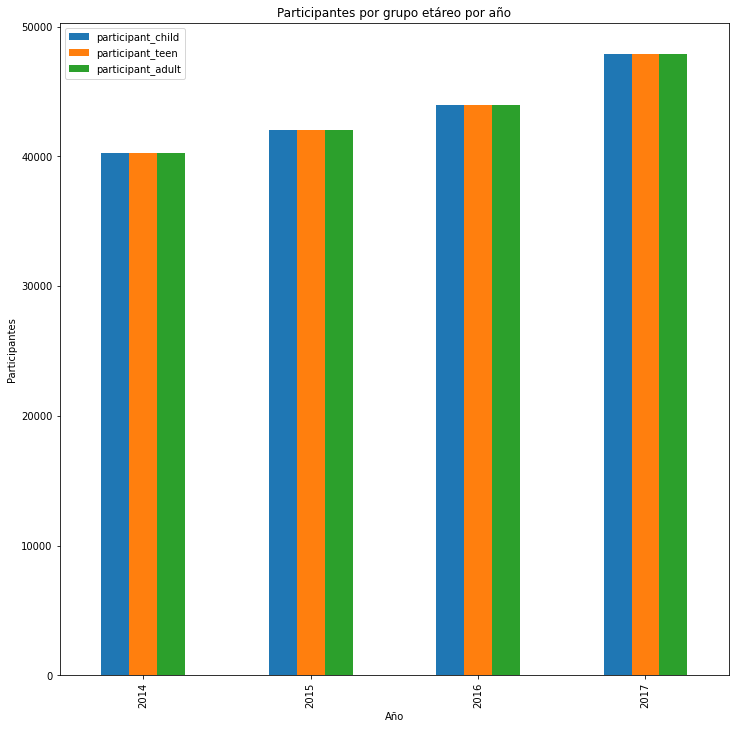

In [9]:
#participantes por grupo etáreo por año
gun_violence = gun_violence.reset_index(drop=True)
ge_año = gun_violence.groupby(['year']).sum()
ge_año[['participant_child','participant_teen','participant_adult']].plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Participantes')
plt.title('Participantes por grupo etáreo por año')

Text(0.5, 1.0, 'Participantes por tipo por año')

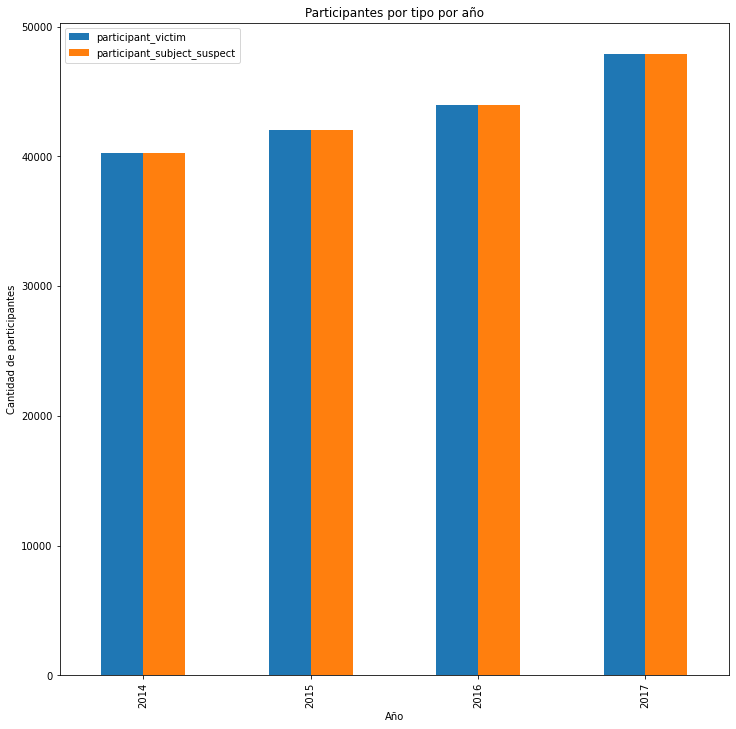

In [10]:
#participantes por tipo por año
gun_violence = gun_violence.reset_index(drop=True)
tipo_año = gun_violence.groupby(['year']).sum()
tipo_año[['participant_victim','participant_subject_suspect']].plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por tipo por año')

Text(0.5, 1.0, 'Participantes por estado por año')

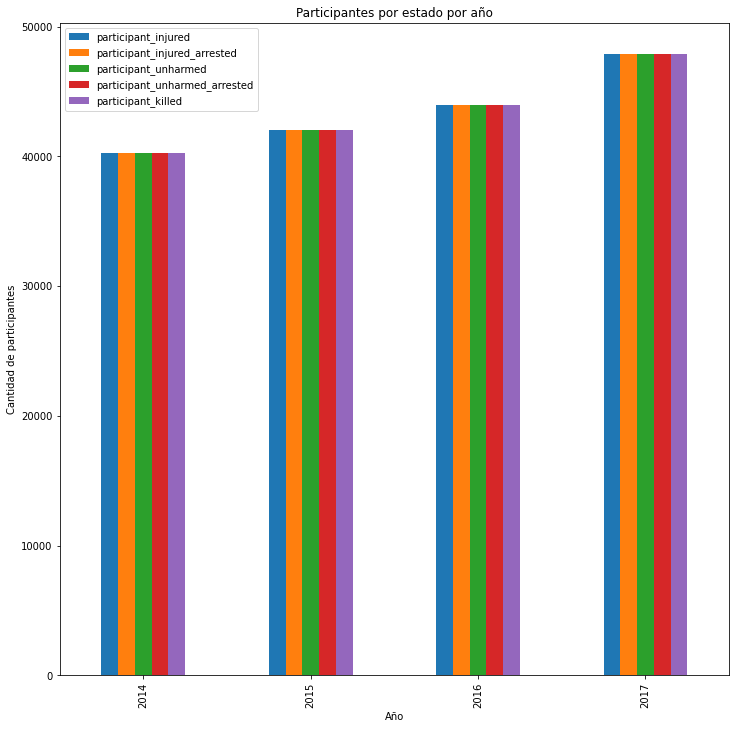

In [11]:
#participantes por status por año
gun_violence = gun_violence.reset_index(drop=True)
status_año = gun_violence.groupby(['year']).sum()
status_año[['participant_injured','participant_injured_arrested',	'participant_unharmed',	'participant_unharmed_arrested',	'participant_killed']].plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por estado por año')

Text(0.5, 1.0, 'Participantes por grupo etáreo por estado')

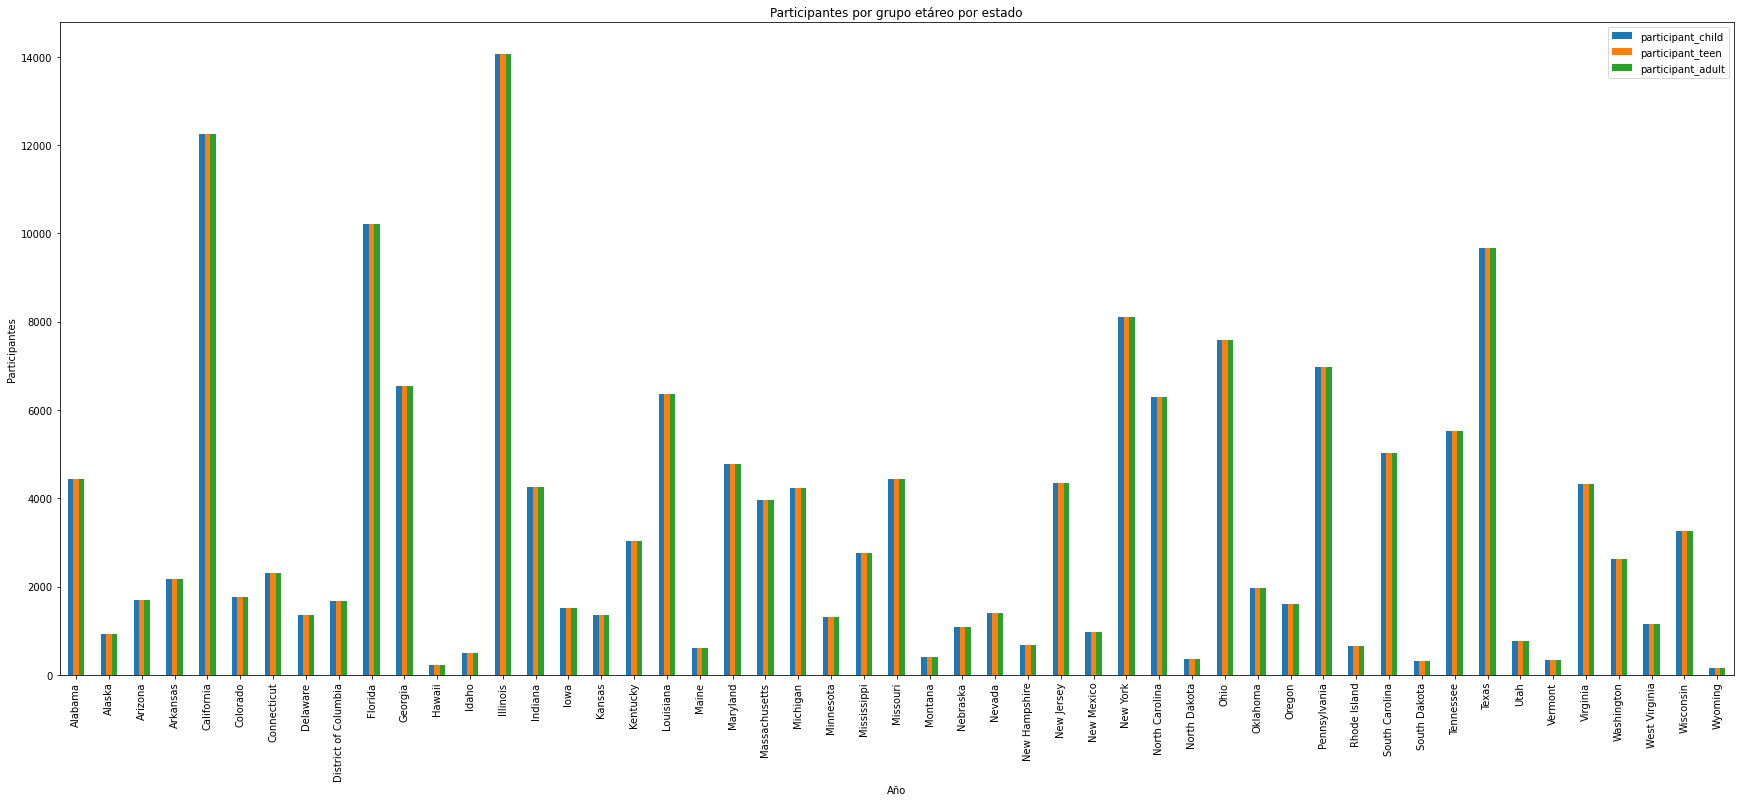

In [12]:
#participantes por grupo etáreo por estado
gun_violence = gun_violence.reset_index(drop=True)
ge_state = gun_violence.groupby(['state']).sum()
ge_state[['participant_child','participant_teen','participant_adult']].plot.bar(figsize=(30, 12))
plt.xlabel('Año')
plt.ylabel('Participantes')
plt.title('Participantes por grupo etáreo por estado')

Text(0.5, 1.0, 'Participantes por sexo por año')

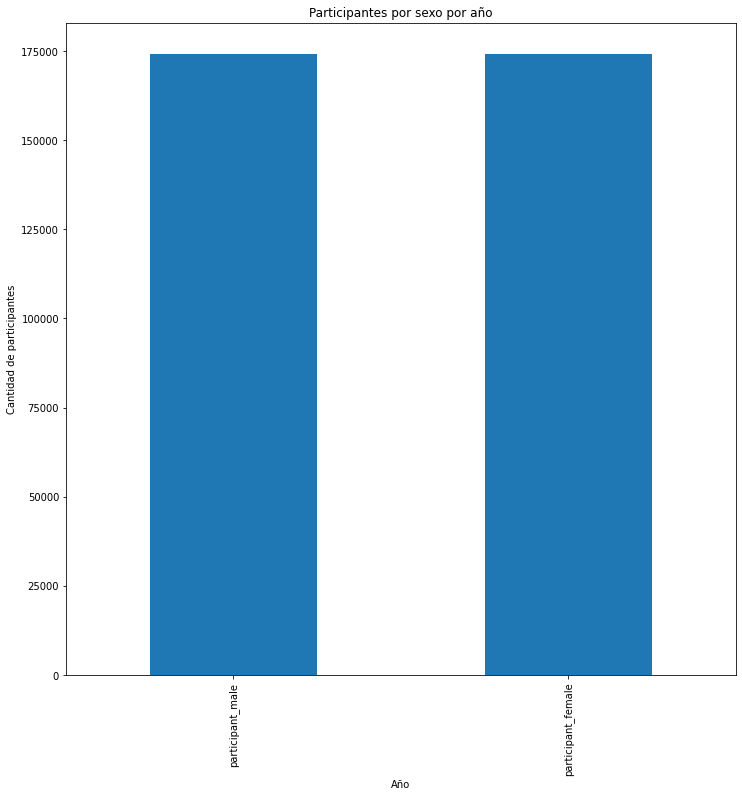

In [13]:
#participantes por sexo por año
gun_violence = gun_violence.reset_index(drop=True)
sexo_año = gun_violence[['participant_male', 'participant_female']].sum()
sexo_año.plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por sexo por año')

In [14]:
sexo_año[['participant_male','participant_female']]

participant_male      174233
participant_female    174233
dtype: int64

Text(0.5, 1.0, 'Participantes por sexo por año')

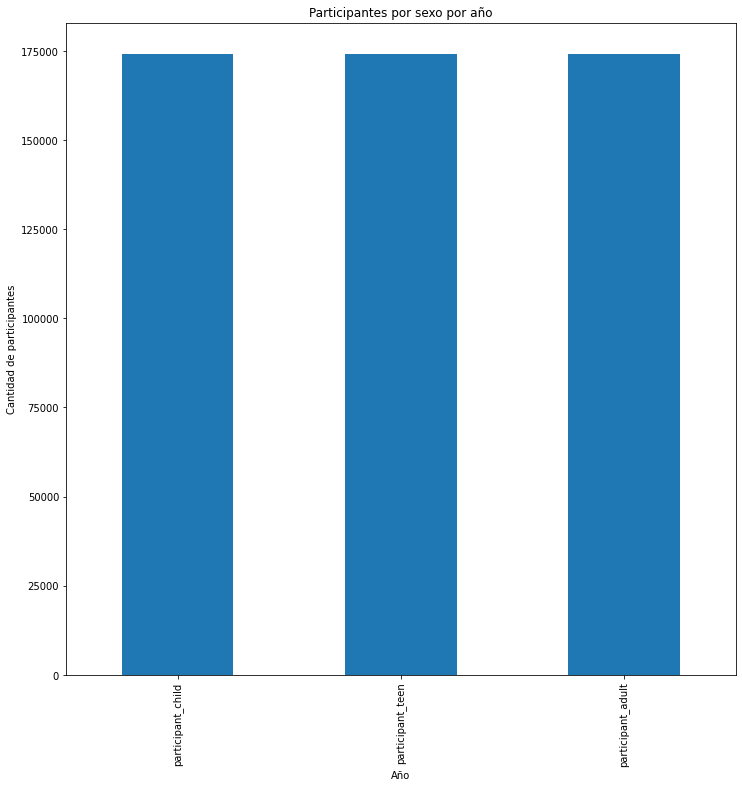

In [15]:
#participantes por sexo por año
gun_violence = gun_violence.reset_index(drop=True)
sexo_año = gun_violence[['participant_child', 'participant_teen', 'participant_adult']].sum()
sexo_año.plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por sexo por año')

#Probamos relaciones
Probando correlaciones mediante una matriz

In [16]:

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)


gun_aux = gun_violence.drop(['gun_type','latitude', 'incident_id', 'longitude', 'incident_characteristics', 'participant_male','participant_female', 'participant_child', 'participant_teen','participant_adult','participant_injured',
                             'participant_injured_arrested','participant_unharmed','participant_unharmed_arrested','participant_killed', 'participant_victim','participant_subject_suspect'], axis=1)
corr_matrix = gun_aux.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10000)


,variable_1,variable_2,r,abs_r
393,participant_victim_injured,n_injured,0.949106,0.949106
42,n_injured,participant_victim_injured,0.949106,0.949106
476,participant_victim_killed,n_killed,0.915605,0.915605
17,n_killed,participant_victim_killed,0.915605,0.915605
634,participant_suspect_adult,participant_suspect_male,0.810100,0.810100
...,...,...,...,...
324,participant_victim_child,participant_victim_unharmed_arrested,0.000105,0.000105
221,state_n,participant_suspect_unharmed,0.000079,0.000079
707,participant_suspect_unharmed,state_n,0.000079,0.000079
543,participant_suspect_female,participant_victim_child,-0.000072,0.000072


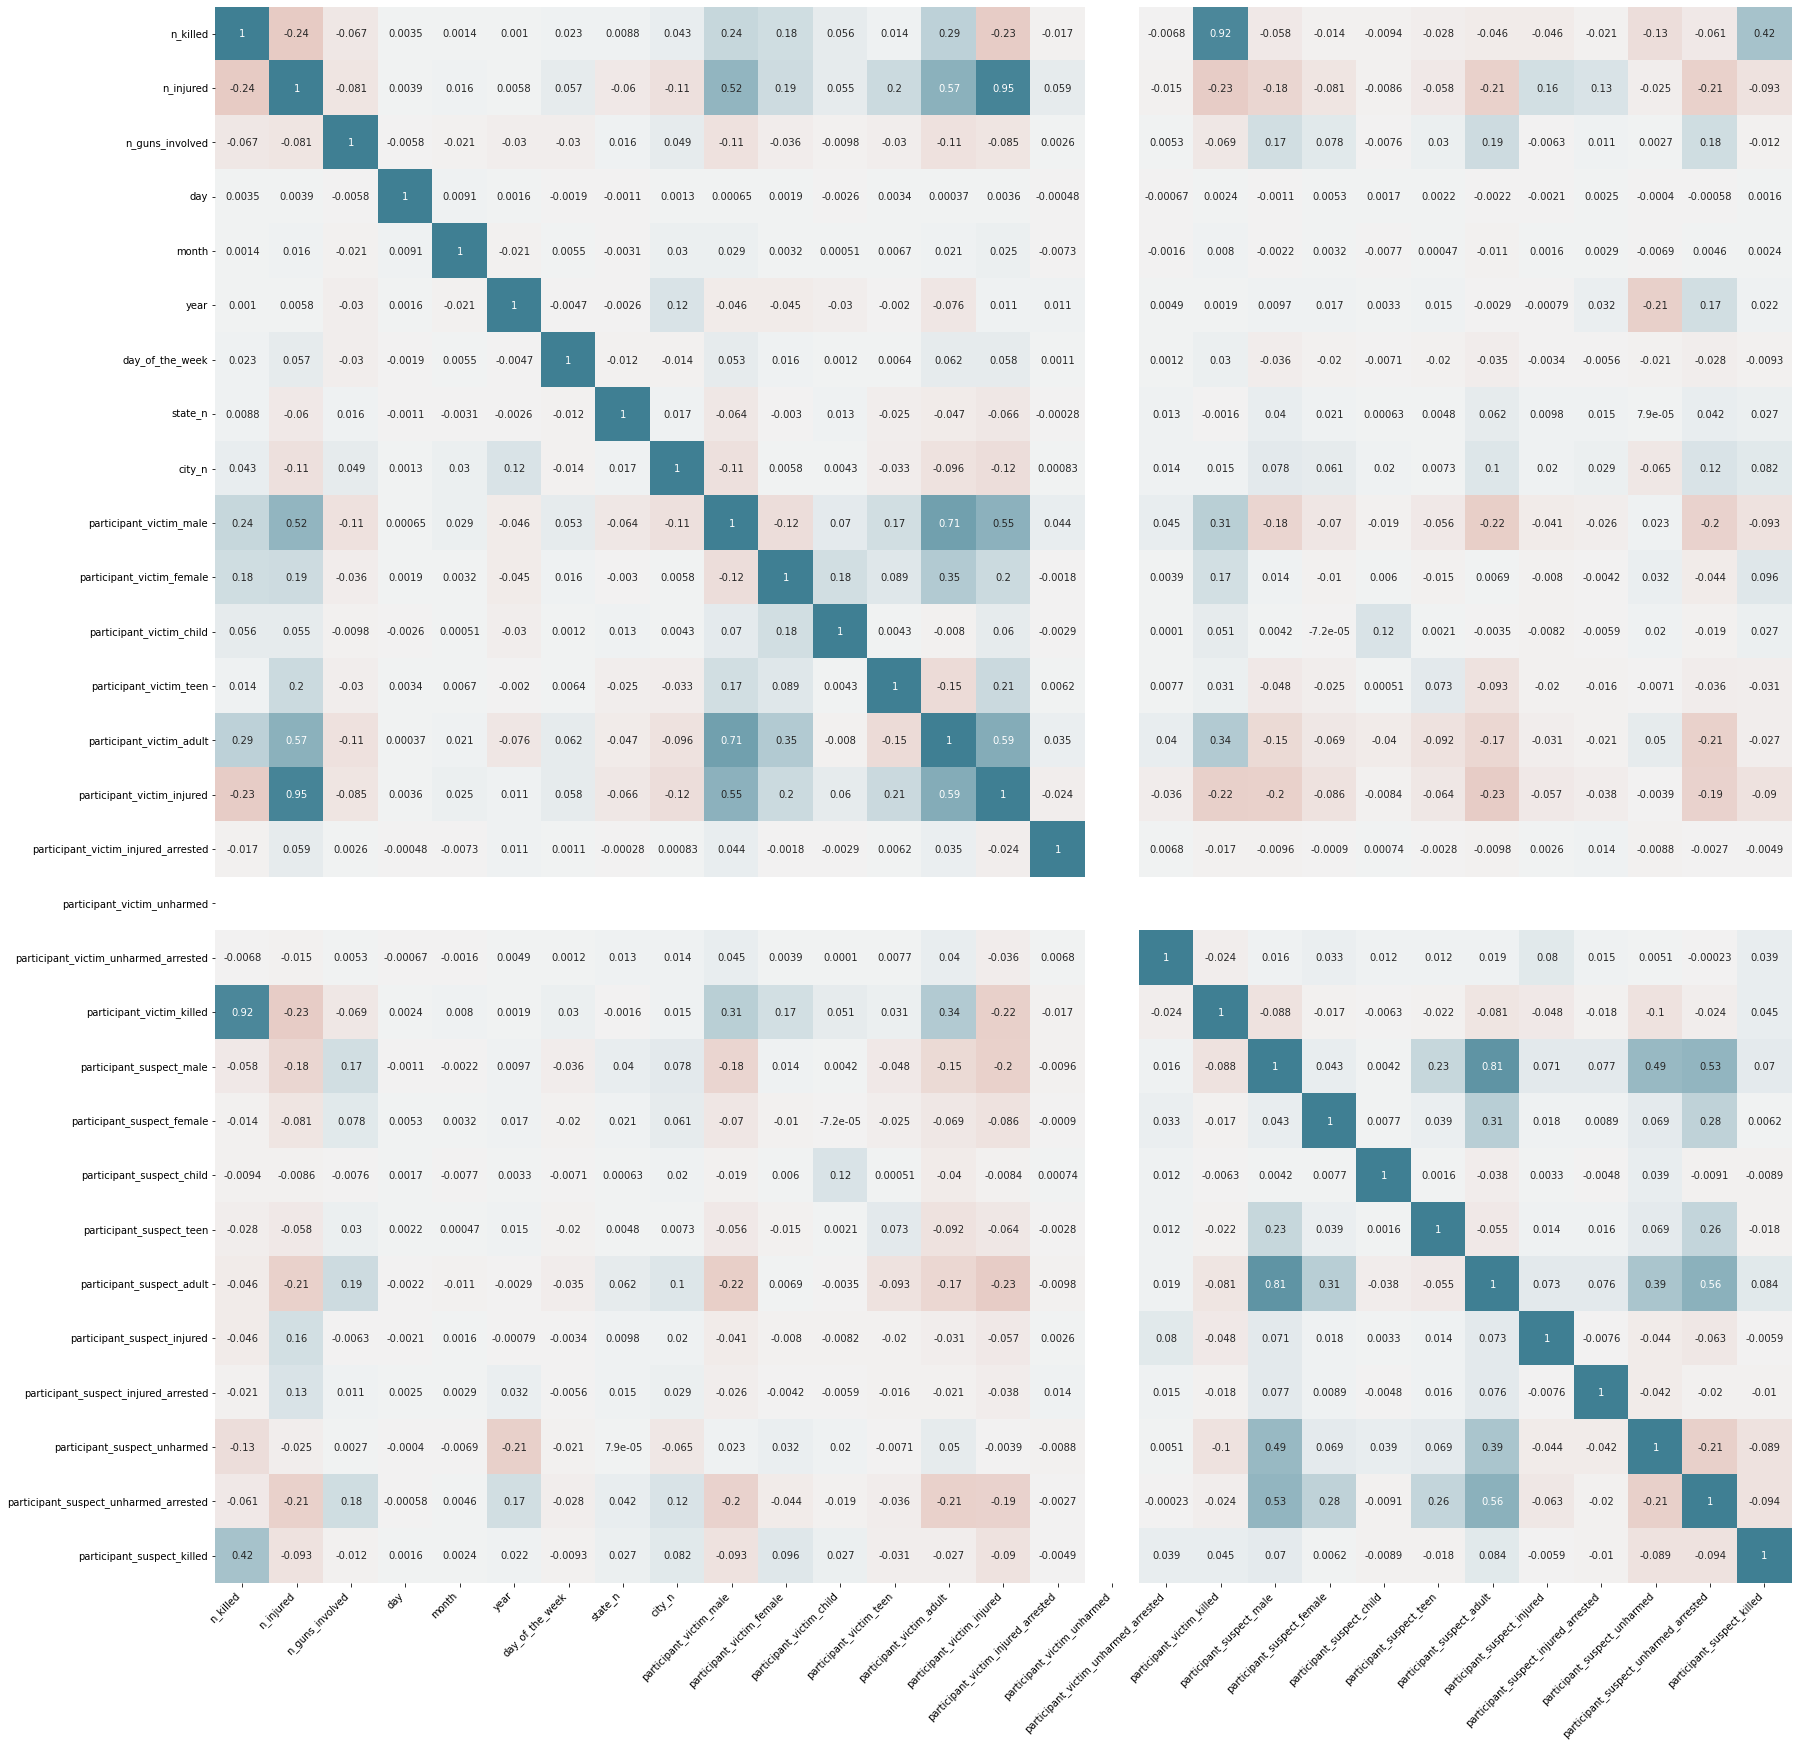

In [17]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(29, 29))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)